In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
total_ret_idx = pd.read_csv('/projects/Polygon/data/grf/totindex.csv', header=0, index_col=0, parse_dates=True)
total_ret = total_ret_idx.pct_change(1)
prc_idx = pd.read_csv('/projects/Polygon/data/grf/priceindex.csv', header=0, index_col=0, parse_dates=True)
prc_ret = prc_idx.pct_change(1)
fut_idx = pd.read_csv('/projects/Polygon/data/grf/FutGenratio1.csv', header=0, index_col=0, parse_dates=True)
fut_idx.index = pd.to_datetime(fut_idx.index, unit = 'D', origin = '1899-12-30')
fut_ret = fut_idx.pct_change(1)

# add price return to any NA row of total return DataFrame
no_data_dates = total_ret[(total_ret.isnull().sum(axis=1) > 0).values].index
total_ret.loc[no_data_dates] = prc_ret.loc[no_data_dates]
# Make ERet by below rule
ERet = pd.concat([total_ret.loc[:'2007-12-31'], fut_ret.loc['2008-01-01':]], axis=0).iloc[1:]

ERet.fillna(0, inplace=True)
Eindex = (1. + ERet).cumprod()

In [6]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [8]:
# what are all RET, ERet, Ret??????
RET = ERet  
RETfinal = RET

for statrun in range(2):
    if statrun ==0:
        RET = ERet.iloc[:, :10]
    elif statrun==1:
        RET = ERet.iloc[:, 10:14]          
    index=Eindex.loc[:, RET.columns]

    fundwgt=1
    statwgt=1
    minobs=500
    Expanding=1
    short=0.2
    day1=24#rebalance 
    day2=7
    nopos=0.4##middle section->neutral zone
    MA=[x /15 for x in [1,2,3,4,5]]
     # assets to long and short
    CS=0.35
    #Factor Portfolio construction
    Assetvol=0.02
    Strategyvol=0.02
    factorvol=0.02
    factorsd=260
    assetsd=260
    statsd=260
    ##volupdate trigger
    Volband=0.1

    ##carry score
    # create dates of 1 business day after the original dates: TOM
    Ret=ERet

    # test = Ret.index[Ret.index.weekday]
    # print(test)
    # print(Ret[Ret.index.weekday<5].tail())
    # print(Ret.index)
    # print(Ret.index.shift(1, freq='B'))
    # bdays = pd.bdate_range(start = Ret.index[0], end = Ret.index[-1])
    # TOM = bdays.shift(1)

    # its date are used as values and its origianl index should be Ret
    TOM = Ret.index + pd.tseries.offsets.BDay(1)


    # TODO: why use TOM???? to check next business date and keep the matrix shape for TOM2


    # cal <- create.calendar("Actual",weekdays=c("saturday", "sunday"))
    # TOM=as.data.frame(day(add.bizdays(rownames(Ret),1,cal)))
    # rownames(TOM)=rownames(Ret)
    # TOM2=TOM*0-1*short

    # TOM = np.ones(len(TOM))

    # initial signal
    # when rebalancing long the position
    # TOM2[TOM[,1]>=day1,1]=1
    # TOM2[TOM2.index >= day1] = 1

    TOM2 = pd.DataFrame([-short]*len(TOM), index = Ret.index)
    TOM2[TOM.day >= day1] =1
    SIG=Ret*0+1
    SIG=pd.DataFrame(SIG.values* TOM2.values, index = TOM2.index, columns = Ret.columns)

    TSRV1=SIG*fundwgt#+SIG2

    # 1day forward signal of 0.2 since short =0.2

    short=0
    CSRV=index*0
    
    
    # # 1m shifted year month in Ret
    # statday=unique(as.yearmon(rownames(Ret))+1/12)

    # # DF with index columns and index without the first 3 years in Ret
    # # end up with months in bible and months in Ret

    # bible= pd.DataFrame(0,nrow=(length(statday)-36),ncol=ncol(index))
    # bible$YM=statday[(36+1-short):(length(statday)-short)]
    # bible$mon=month(bible$YM)

    # Ret$YM=as.yearmon(rownames(Ret))
    # Ret$mon=month(rownames(Ret))

    statday = (Ret.index+pd.tseries.offsets.DateOffset(months =1)).strftime('%Y-%m').unique()
    bible_idx = statday[36-short:len(statday)-short]
    # print(bible_idx, bible_idx.dt.to_period('M'))
    
    # # what to do with this?
    # # looping every day in bible 
    # # to find average 3 years of Ret but excluding when months are the same
    # # to find 3 years of mean/sd which includes the same month 

    # for (i in 1:nrow(bible)){
    #   ave=(colMeans(Ret[Ret$YM<(bible$YM[i]) 
    #                     & Ret$YM>=statday[i]
    #                     & Ret$mon!=bible$mon[i],
    #                     1:ncol(index)],
    #                 na.rm=TRUE))

    #   bible[i,1:ncol(index)]=(colMeans(Ret[Ret$YM<(bible$YM[i])
    #                                        & Ret$YM>=statday[i]
    #                                        & Ret$mon==bible$mon[i],
    #                                        1:ncol(index)],
    #                                    na.rm=TRUE))/
    #                             colSds(as.matrix(Ret[Ret$YM<(bible$YM[i]) 
    #                                              & Ret$YM>=statday[i]
    #                                              & Ret$mon==bible$mon[i],
    #                                              1:ncol(CSRV)]),
    #                                    na.rm=TRUE)
    # }

    bible_ls = []

    # why compute ave??
    for i in range(len(bible_idx)):
        ave = np.mean(Ret[(Ret.index < bible_idx[i]) & (Ret.index >= statday[i]) & (Ret.index.month!= pd.to_datetime(bible_idx[i]).month)], axis=0)
        ave = ave.iloc[:len(index.columns)]
        bible_temp = np.mean(Ret[(Ret.index < bible_idx[i]) & (Ret.index >= statday[i]) & (Ret.index.month== pd.to_datetime(bible_idx[i]).month)], axis=0)/ \
                    np.std(Ret[(Ret.index < bible_idx[i]) & (Ret.index >= statday[i]) & (Ret.index.month== pd.to_datetime(bible_idx[i]).month)], axis=0) 
        bible_ls.append(bible_temp.iloc[:len(index.columns)])    
        

    bible = pd.DataFrame(bible_ls, index = bible_idx)

    # RV represents right value?? or rank value???
    RV1=bible.iloc[:,:len(index.columns)]
    print('rv1:', RV1)
    
    # truecount=matrix(rep(truecount,ncol(RV1)),nrow=nrow(RV1))
    truecount= np.round(1 - np.sum(np.isnan(RV1), axis =1)*CS)
    truecount = np.tile(truecount, (len(RV1.columns), 1))
    print('truecount:' , truecount)

    # bibleRV=as.data.frame(t(as.data.frame(apply(RV1,1,rank,ties.method="first",na.last="keep"))))
    # bibleRV1=as.data.frame(t(as.data.frame(apply(-RV1,1,rank,ties.method="last",na.last="keep"))))

    # lower value lower rank
    bibleRV = RV1.rank(axis=1, method = 'first').T
    bibleRV1 = (-RV1).rank(axis=1, method = 'first').T
    print('bibleRV: ', bibleRV)
    print('bibleRV1: ', bibleRV1)

    # bibleRVpos=bibleRV*0
    # bibleRVpos[bibleRV[,]<=truecount]=-1
    # bibleRVpos[bibleRV1[,]<=truecount]=1

    # lowest value in RV : -1(short), highest: 1 (long)
    bibleRVpos=bibleRV*0
    bibleRVpos[bibleRV<=truecount]=-1
    bibleRVpos[bibleRV1<=truecount]=1
    print('bibleRVpos: ', bibleRVpos)

    #   CSRV=CSRV[as.yearmon(rownames(CSRV))>=bible$YM[1],]
    # CSRV=CSRV[CSRV.index.strftime('%Y-%m')>=bible_idx[0]]


    # #####need to adjust due to month end rebalancing(get Nov on oct/31)
    # for(i in 1:nrow(bible)){
    #   CSRV[as.yearmon(rownames(CSRV))==(bible$YM[i]-1/12),1:ncol(index)]=bibleRVpos[i,1:ncol(index)]*statwgt
    # }

    # assign bibleRVpos to CSRV when year and month are mathced with 1 month backward bible year and month?? 
    # it just compares with a date. why?????
    for i in range(len(bible)):
        CSRV_ym = (pd.to_datetime(bible_idx[i])-pd.tseries.offsets.DateOffset(months =1)).strftime('%Y-%m')
        CSRV_range = CSRV[CSRV.index.strftime('%Y-%m') ==CSRV_ym]
        CSRV[CSRV.index.strftime('%Y-%m') ==CSRV_ym] = [bibleRVpos.iloc[:, i]*statwgt]*CSRV_range.shape[0]

    print('csrv: ', CSRV)
    # bibleTS1=bible[,1:ncol(index)]
    # bibleTS=bibleTS1*0
    # bibleTS[bibleTS1[]<(-0.5)]=-1
    # bibleTS[bibleTS1[]>(0.5)]=1
    # TSRV=CSRV*0
    # for(i in 1:nrow(bible)){
    #   TSRV[as.yearmon(rownames(TSRV))==bible$YM[i],1:ncol(index)]=bibleTS[i,1:ncol(index)]
    # }

    # different from CSRV, bibleTS is not transposed 
    # is it because it is a time series? not cross sectional?
    bibleTS1=bible
    bibleTS=bibleTS1*0
    bibleTS[bibleTS1<(-0.5)]=-1
    bibleTS[bibleTS1>(0.5)]=1
    TSRV=CSRV*0
    for i in range(len(bible)):
        TSRV_ym = (pd.to_datetime(bible_idx[i])).strftime('%Y-%m')
        TSRV_range = TSRV[TSRV.index.strftime('%Y-%m') ==TSRV_ym]
        TSRV[TSRV.index.strftime('%Y-%m') ==TSRV_ym] = [bibleTS.iloc[i, :]]*TSRV_range.shape[0]

    print('tsrv: ', TSRV)
    # AAA=intersect(rownames(TSRV1),rownames(TSRV))
    # TSRV1=TSRV1[AAA,]
    # TSRV=TSRV[AAA,]

    AAA = [x for x in TSRV1 if x in TSRV]
    TSRV1 = TSRV1.loc[:, AAA]
    TSRV = TSRV.loc[:, AAA]

#     print(TSRV1.iloc[-10:, :])
#     print(TSRV.iloc[-10:, :])        

    # TSRV=TSRV1*1+TSRV*0
    # AAA=intersect(rownames(TSRV),rownames(CSRV))
    # CSRV=CSRV[AAA,]
    # TSRV=TSRV[AAA,]

    TSRV=TSRV1*1+TSRV*0
    AAA = pd.Index(TSRV.index).intersection(CSRV.index)
    CSRV = CSRV.loc[AAA,:]
    TSRV = TSRV.loc[AAA,:]

#     print(CSRV.tail())
#     print(TSRV.tail())

    # if(statrun==1){
    #   TSRVrun1=TSRV
    #   CSRVrun1=CSRV

    # }
    # if(statrun==2){
    #   TSRVrun2=TSRV
    #   CSRVrun2=CSRV
    # }
    if statrun==0:
      TSRVrun1=TSRV
      CSRVrun1=CSRV


    if statrun==1:
      TSRVrun2=TSRV
      CSRVrun2=CSRV


truecount: [[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
bibleRV:        1991-02  1991-03  1991-04  1991-05  1991-06  1991-07  1991-08  1991-09  \
SPX       6.0      3.0      7.0      7.0      1.0      6.0      4.0      9.0   
TSX       7.0      6.0      1.0      4.0      4.0      5.0      1.0      3.0   
FTSE      2.0      4.0      3.0      6.0      3.0      3.0      3.0      5.0   
DAX       9.0      8.0      2.0      3.0      6.0      8.0      6.0      6.0   
CAC      10.0      5.0     10.0      8.0      2.0      2.0      7.0     10.0   
SMI       8.0      1.0      4.0      5.0     10.0      7.0      9.0      4.0   
MIB       3.0      9.0      5.0      1.0      9.0      4.0      8.0      7.0   
IBEX      1.0      2.0      9.0      9.0      7.0      1.0     10.0      2.0   
OMX       5.0      7.0      8.0     10.0      8.0     10.0      2.0      1.0   
AEX       4.0     10.0 

bibleRVpos:        1991-02  1991-03  1991-04  1991-05  1991-06  1991-07  1991-08  1991-09  \
SPX       0.0      0.0      0.0      0.0     -1.0      0.0      0.0      0.0   
TSX       0.0      0.0     -1.0      0.0      0.0      0.0     -1.0      0.0   
FTSE      0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
DAX       0.0      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
CAC       1.0      0.0      1.0      0.0      0.0      0.0      0.0      1.0   
SMI       0.0     -1.0      0.0      0.0      1.0      0.0      0.0      0.0   
MIB       0.0      0.0      0.0     -1.0      0.0      0.0      0.0      0.0   
IBEX     -1.0      0.0      0.0      0.0      0.0     -1.0      1.0      0.0   
OMX       0.0      0.0      0.0      1.0      0.0      1.0      0.0     -1.0   
AEX       0.0      1.0      0.0      0.0      0.0      0.0      0.0      0.0   

      1991-10  1991-11  ...  2017-09  2017-10  2017-11  2017-12  2018-01  \
SPX       0.0      0.0  ...   

truecount: [[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
bibleRV:        1991-02  1991-03  1991-04  1991-05  1991-06  1991-07  1991-08  1991-09  \
SPX       2.0      1.0      4.0      4.0      1.0      3.0      3.0      4.0   
TSX       3.0      3.0      1.0      2.0      3.0      2.0      1.0      1.0   
FTSE      1.0      2.0      3.0      3.0      2.0      1.0      2.0      2.0   
DAX       4.0      4.0      2.0      1.0      4.0      4.0      4.0      3.0   

      1991-10  1991-11  ...  2017-09  2017-10  2017-11  2017-12  2018-01  \
SPX       2.0      3.0  ...      3.0      4.0      3.0      2.0      1.0   
TSX       3.0      1.0  ...      1.0      1.0      2.0      1.0      4.0   
FTSE      1.0      4.0  ...      4.0      2.0      1.0      4.0      3.0   
DAX       4.0      2.0  ...      2.0      3.0      4.0      3.0      2.0   

      2018-02  2018-03  2018-04  2018-05  2018-06  
SPX       4.0      3.0      2.0      3.0    

In [28]:
# TSRV=cbind(TSRVrun1,TSRVrun2)[,colnames(ERet)]
# CSRV=cbind(CSRVrun1,CSRVrun2)[,colnames(ERet)]

TSRV = pd.concat([TSRVrun1, TSRVrun2], axis=1)
CSRV = pd.concat([CSRVrun1, CSRVrun2], axis=1)


In [27]:
print(TSRVrun1.tail())
print(CSRVrun1.tail())
print(TSRVrun2.tail())
print(CSRVrun2.tail())

            SPX  TSX  FTSE  DAX  CAC  SMI  MIB  IBEX  OMX  AEX
2018-05-03 -0.2 -0.2  -0.2 -0.2 -0.2 -0.2 -0.2  -0.2 -0.2 -0.2
2018-05-04 -0.2 -0.2  -0.2 -0.2 -0.2 -0.2 -0.2  -0.2 -0.2 -0.2
2018-05-07 -0.2 -0.2  -0.2 -0.2 -0.2 -0.2 -0.2  -0.2 -0.2 -0.2
2018-05-08 -0.2 -0.2  -0.2 -0.2 -0.2 -0.2 -0.2  -0.2 -0.2 -0.2
2018-05-09 -0.2 -0.2  -0.2 -0.2 -0.2 -0.2 -0.2  -0.2 -0.2 -0.2
            SPX  TSX  FTSE  DAX  CAC  SMI  MIB  IBEX  OMX  AEX
2018-05-03  1.0  0.0   0.0  0.0  0.0 -1.0  0.0   0.0  0.0  0.0
2018-05-04  1.0  0.0   0.0  0.0  0.0 -1.0  0.0   0.0  0.0  0.0
2018-05-07  1.0  0.0   0.0  0.0  0.0 -1.0  0.0   0.0  0.0  0.0
2018-05-08  1.0  0.0   0.0  0.0  0.0 -1.0  0.0   0.0  0.0  0.0
2018-05-09  1.0  0.0   0.0  0.0  0.0 -1.0  0.0   0.0  0.0  0.0
            NKY  AS51  HSI   SG
2018-05-03 -0.2  -0.2 -0.2 -0.2
2018-05-04 -0.2  -0.2 -0.2 -0.2
2018-05-07 -0.2  -0.2 -0.2 -0.2
2018-05-08 -0.2  -0.2 -0.2 -0.2
2018-05-09 -0.2  -0.2 -0.2 -0.2
            NKY  AS51  HSI   SG
2018-05-03  1.0   0.

In [29]:
def ex_ante_vol(df_ret, todate, weights, lookback=130, shrink_corr=0.9):
    '''
    Args:
        df_ret: pandas DataFrame of returns
        todate: date to calculate ex ante vol
        weights: weight of strategy before ex ante vol control
        lookback: number of days to consider for calculating cov
        shrink_corr: weight to shrink correlation
    '''
    # setting data range
    todate_loc = df_ret.index.get_loc(todate)
    if todate_loc > lookback:
        fromdate_loc = todate_loc - lookback
    else:
        fromdate_loc = 0
    
    # calculate corr apply shrinkage
    corr = df_ret.iloc[fromdate_loc:todate_loc].corr()
    corr = corr * shrink_corr + np.diag(np.ones(len(df_ret.columns))) * (1.- shrink_corr)
    # calculate cov
    std = df_ret.iloc[fromdate_loc:todate_loc].std()
    cov = pd.DataFrame(np.diag(std).dot(corr).dot(np.diag(std)), index=RET.columns, columns=RET.columns)
    # calculate ex ante vol
    return np.sqrt(weights.dot(cov).dot(weights)) * np.sqrt(260)

class GRP_bt:
    '''
    '''
    def __init__(self, CSLS, RET, RB, min_vol, freq):
        '''
        '''
        self.CSLS = CSLS  # Cross Sectional Exposure Type. 'vol' means volatility allocation. 'notional' means notional. 
        self.RET = RET  # 
        self.RB = RB
        
        self.Assetvol = 0.02 # vol control parameter for individual assets
        self.Strategyvol = 0.02 # vol control parameter for whole strategy
        self.factorvol = 0.02
        self.factorsd = 260 # lookback period for calcualting factorvol
        self.assetsd = 90 # lookback period for calculating Assetvol
        self.statsd = 90 # lookback period for calcualting Strategyvol

        self.volband = 0.05 # if controled vol is within volband, do not change vol
        self.min_vol = min_vol # vol floor 0.04 for ir strategy, 0.15 for all otheres
        self.freq = freq # strategy frequency setting. it only applys to Cross Sectional backtesting now.
        
        # Calculating volatility for assets
        std = (self.RET.rolling(window=self.assetsd).std() * np.sqrt(260)).iloc[self.assetsd:]
        # Adjust calculated asset volatility
        self.std_adj = self.adjust_by_volband(std, self.volband, min_vol=self.min_vol)

    def adjust_by_volband(self, df_vol, volband, min_vol=None):
        for i in range(1, len(df_vol.index)):
            if df_vol.iloc[i].name.weekday() == self.RB:
                for c in range(len(df_vol.columns)):
                    # case1. if new std is null
                    if pd.isnull(df_vol.iloc[i, c]):
                        df_vol.iloc[i, c] = df_vol.iloc[i-1, c]
                    # case2. if new std within volband
                    if abs(df_vol.iloc[i, c] - df_vol.iloc[i-1, c]) < volband * df_vol.iloc[i-1, c] :
                        df_vol.iloc[i, c] = df_vol.iloc[i-1, c]
            else:
                df_vol.iloc[i] = df_vol.iloc[i-1]
        if min_vol is not None:
            df_vol[df_vol < min_vol] = min_vol

        return df_vol
    
    def ts_vol_control_backtest(self, TSRV):
        # Time Series 
        VCweight = self.Assetvol / self.std_adj
        VCTSpos = (VCweight * TSRV).loc[TSRV.index[0]:] # Vol Control Time Series Position
        VCTSpos.replace([np.inf, -np.inf], np.nan, inplace=True)
        
        # Strategy level vol control
        # return of VC strategy
        Strategy = ((self.RET * VCTSpos.shift(1)).sum(axis=1)).loc[TSRV.index[0]:]
        # using average of expanding & moving window strategy risk
        Strategyrisk_expanding = (Strategy.expanding(min_periods=self.statsd).std()*np.sqrt(260)).iloc[self.statsd:]
        Strategyrisk_rolling = (Strategy.rolling(window=self.statsd).std()*np.sqrt(260)).iloc[self.statsd:]
        Strategyrisk = (Strategyrisk_expanding + Strategyrisk_rolling) / 2.
        # volband adjustment
        bufrisk = self.adjust_by_volband(Strategyrisk.copy().to_frame(), self.volband)
        # apply strategy level vol control to position
        statlev = self.Strategyvol / bufrisk.iloc[:,0]
        self.TSposition = VCTSpos.multiply(statlev, axis='index').iloc[self.statsd:]
        self.TSposition.replace([np.inf, -np.inf], np.nan, inplace=True)
        self.TSposition.fillna(0, inplace=True)
        
        # calculate daily strategy return
        self.TSStrategy = (self.RET * self.TSposition.shift(1)).sum(axis=1).loc[TSRV.index[0]:]
        self.TSStrategylag = (self.RET * self.TSposition.shift(2)).sum(axis=1).loc[TSRV.index[0]:]
    
    def cs_vol_control_backtest(self, CSRV):
        if self.CSLS == 'vol':
            CSRV = (CSRV * self.Assetvol / self.std_adj).loc[CSRV.index[0]:]
        #elif self.CSLS != 'notional': # raise error
            
        # Calculating Ex-ante Vol and adjust to target vol which specified by 'Strategyvol'
        if self.freq == 'week':
            for i in range(len(CSRV.index)):
                if CSRV.iloc[i].name.weekday() == self.RB:
                    CSRV.iloc[i] = CSRV.iloc[i] * self.Strategyvol / ex_ante_vol(self.RET, CSRV.iloc[i].name, CSRV.iloc[i])
                else:
                    CSRV.iloc[i] = CSRV.iloc[i-1]
        elif self.freq == 'month':
            for i in range(len(CSRV.index)):
                if CSRV.iloc[i].name.month != CSRV.iloc[i-1].name.month:
                    CSRV.iloc[i] = CSRV.iloc[i] * self.Strategyvol / ex_ante_vol(self.RET, CSRV.iloc[i].name, CSRV.iloc[i])
                else:
                    CSRV.iloc[i] = CSRV.iloc[i-1]
        #else: # raise error
            
        # Strategy level vol control
        # return of VC strategy
        CSraw = (self.RET * CSRV.shift(1)).dropna(how='all').sum(axis=1)
        CSrisk = (CSraw.rolling(window=self.statsd).std()*np.sqrt(260)).iloc[self.statsd:]
        
        # volband adjustment
        cs_bufrisk = self.adjust_by_volband(CSrisk.to_frame(), self.volband)
        # apply strategy level vol control to position
        cs_statlev = self.Strategyvol / cs_bufrisk.iloc[:,0]
        self.CSposition = CSRV.multiply(cs_statlev, axis='index').iloc[self.statsd:]
        self.CSposition.replace([np.inf, -np.inf], np.nan, inplace=True)
        self.CSposition.fillna(0, inplace=True)
        
        # calculate daily strategy return
        self.CSStrategy = (self.RET * self.CSposition.shift(1)).sum(axis=1).loc[CSRV.index[0]:]
        self.CSStrategylag = (self.RET * self.CSposition.shift(2)).sum(axis=1).loc[CSRV.index[0]:]

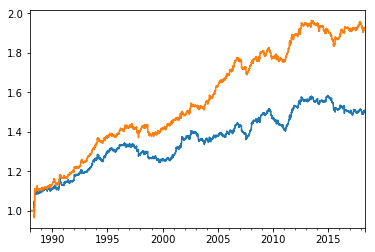

In [30]:
RB = 1
min_vol = .15
freq = 'month'

GRP_bt_test = GRP_bt('vol', ERet, RB, min_vol, freq)
GRP_bt_test.ts_vol_control_backtest(TSRV)

(1. + GRP_bt_test.TSStrategy).cumprod().plot()
(1. + GRP_bt_test.TSStrategylag).cumprod().plot()

In [273]:




print(match.call()[[1]])
name1=match.call()[[1]]
Ret=RETfinal
if(write==1){
setwd("D:/R/GRP/live")

write.csv(TSRV,paste(name1,"TS.csv",sep=""))
write.csv(CSRV,paste(name1,"CS.csv",sep=""))
setwd("D:/R/GRP")
}
if(test!=1){

setwd("D:/R/GRP/live")
##########
TSRVnew=TSRV
CSRVnew=CSRV
TSRVlive=as.data.frame(read.csv(paste(name1,"TS.csv",sep=""), row.names=1,header=TRUE))
CSRVlive=as.data.frame(read.csv(paste(name1,"CS.csv",sep=""), row.names=1,header=TRUE))
TSRVnew[rownames(TSRVlive),]=TSRVlive
CSRVnew[rownames(CSRVlive),]=CSRVlive

if (updatedaily==1){
  write.csv(TSRVnew,paste(name1,"TS.csv",sep=""))
  write.csv(CSRVnew,paste(name1,"CS.csv",sep=""))
  ##########
}
setwd("D:/R/GRP")
}
functionoutput=factor(TSRV,CSRV,Ret,FALSE,CSLS=CSdesign,TSWGT,CSWGT,0,CSweek=0,rpname=name1,BETA=betamat)


# output=functionoutput[[2]]
# write.csv(output,"stat.csv")
E_SS_TS=functionoutput[[1]]
E_SS_CS=functionoutput[[2]]

result=list(functionoutput[[1]],functionoutput[[2]],functionoutput[[3]],functionoutput[[4]])

return result


SyntaxError: invalid syntax (<ipython-input-273-423b0629b5b7>, line 3)